Imports

In [40]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import scipy.fftpack
import time
from IPython.display import HTML

def dst(x):
    return np.real(scipy.fftpack.dst(x,type=1))/2

def idst(x): # default applies transform to last axis of x
    return np.real(scipy.fftpack.dst(x,type=1))*2/(x.shape[0] + 1)

from scipy.integrate import odeint as ode


Math


In [41]:
"""
U'' = T/mu*Uxx - 2*s0*U' + s1*U'xx + E*Uxxxx
S{U} = V
S{U'} = V'
let w = pi*(k + 1)/(N + 1)
S{Uxx} = -(w^2)*V
S{Uxx} = (w^4)*V
V'' = -T/mu*(w^2)*V - 2*s0*V' - s1*(w^2)*V' + E*(w^4)*V
V'' = -(2*s0 + s1*(w^2))V' - (T/mu*(w^2) - E*(w^4))*V
let a = -(2*s0 + s1*(w^2))
let b = -(T/mu*(w^2) - E*(w^4))
V'' = a*V' + b*V
""";

Initial Conditions

In [42]:
# characteristic equation
# U'' = T/mu*Uxx - 2*s0*U' + s1*U'xx + E*Uxxxx

L = 0.648       # m
T = 69.39      # N
mu = 0.02     # kg/m^3
s0 = 1
s1 = 0.1
E = 1.5e-5      
N = 128
pi = np.pi
frequency = 441    # hz
period = 1  # s
samples = int(period*frequency)

# [0,1,2,3,0,-3,-2,-1,0,1,2, . . .] n includes 1,2,3 but not the symmetry points
x = np.linspace(0,L,N+2) 
k = np.linspace(0,N-1,N)
#n = k # probably not needed
t = np.linspace(0,period,samples)

x0 = L/4
#f = (x/x0)*(x<x0) + (L-x)/(L-x0)*(x>=x0)
f = np.sin(pi*x/L)
u0 = f[1:-1] # leave off the endpoints.  They are always zero.
v0 = dst(u0)
vp0 = v0*0 # zeros, same shape as v0

w  = pi*(k + 1)/(N + 1)
w2 = w*w
a  = -(2*s0 + w2*s1)
b  = -(w2*(T/mu - w2*E))


Numerical approach

In [43]:
# u'' = T/mu*uxx - 2*s0*u' + s1*u'xx + E*uxxxx
# U'' = -a*U' - b*U

def f(y, t):
    v = y[0:N]
    vp = y[N:2*N]
    return np.concatenate((vp, a*vp + b*v))

y0 = np.concatenate((v0,vp0))
y = ode(f,y0,t)
v = y[:,0:N]
u = idst(v)

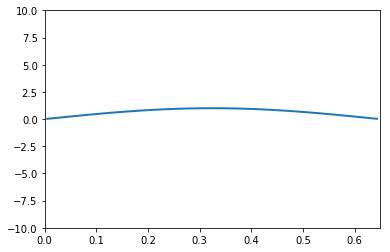

In [46]:

# plt.plot(t,v[:,N//2])
# plt.plot(t,u[:,N//2])
# plt.xlabel('t')
# plt.show()

fig, ax = plt.subplots()
ax.set_xlim(( 0, L))
ax.set_ylim((-10, 10))
line, = ax.plot(x[1:-1], u0, lw=2)

def init():
    line.set_data(x[1:-1], u0)
    return (line,)

def animate(i):
    l.set_data(x[1:-1], u[i,:])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=441, interval=20, blit=True)
rc('animation', html='jshtml')
anim

Exact solution

In [45]:
def exact():
    t = np.linspace(0,period,samples).reshape(1,samples)
    p  = -a/2
    q  = np.sqrt(a*a/4 - b + 0j) 
    l1 = p + q
    l2 = p - q
    r  = l2/l1
    r[0] = 0
    B  = v0/(1-r)
    A  = -r*B
    l1t = np.dot(l1,t)
    l2t = np.dot(l2,t)
    v = A*np.exp(l1t) + B*np.exp(l2t)
    u = idst(v)
    bridge = np.average(v,axis=0)

    y_plot = np.real(u[int(2*N/8),:].reshape(samples,1))
    #y_plot = np.real(bridge.reshape(samples,1))
    t_plot = t.reshape(samples,1)

    print(np.max(y_plot))
    print(np.min(y_plot))
    print(np.average(y_plot))

    plt.plot(t_plot,y_plot)
    plt.show()